In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

import plotly.express as px
import folium
from folium.plugins import heat_map

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from scipy.stats import chi2_contingency, chisquare

from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.preprocessing import LabelEncoder,OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns',32)

In [3]:
df=pd.read_csv('hotel_bookings.csv')
df.head()

hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  children  babies  \
0                        0                     0       2       0.0       0   
1                        0                     0       2       0.0       0   
2                        0                     1       1       0.0       0   
3                        0                     1       1       0.0       0   
4                        0                     2       2       0.0       0   

  meal country market_segment distribution_channel  is_repeated_guest  \
0   BB     PRT         Direct               Direct                  0   
1   BB     PRT         Direct               Direct                  0   
2   BB     GBR         Direct               Direct                  0   
3   BB     GBR      Corporate            Corporate                  0   
4   BB     GBR      Online TA                TA/TO                  0   

   previous_cancellations  previous_bookings_not_canceled reserved_room_type  \
0                       0                               0                  C   
1                       0                               0                  C   
2                       0                               0                  A   
3                       0                               0                  A   
4                       0                               0                  A   

  assigned_room_type  booking_changes deposit_type  agent  company  \
0                  C                3   No Deposit    NaN      NaN   
1                  C                4   No Deposit    NaN      NaN   
2                  C                0   No Deposit    NaN      NaN   
3                  A                0   No Deposit  304.0      NaN   
4                  A                0   No Deposit  240.0      NaN   

   days_in_waiting_list customer_type   adr  required_car_parking_spaces  \
0                     0     Transient   0.0                            0   
1                     0     Transient   0.0                            0   
2                     0     Transient  75.0                            0   
3                     0     Transient  75.0                            0   
4                     0     Transient  98.0                            0   

   total_of_special_requests reservation_status reservation_status_date  
0                          0          Check-Out              01-07-2015  
1                          0          Check-Out              01-07-2015  
2                          0          Check-Out              02-07-2015  
3                          0          Check-Out              02-07-2015  
4                          1          Check-Out              03-07-2015

- Changing location of the target column to the end of the dataset

In [4]:
def arrange_col(df,var):
    col_list = list(df.columns)
    temp = col_list.pop(col_list.index(var))
    return df[col_list+[temp]]

In [5]:
df = arrange_col(df,'is_canceled')

In [6]:
df.shape

(119388, 32)

In [7]:
# Event Rate:
round(df['is_canceled'].value_counts()/df.shape[0],2)

0    0.63
1    0.37
Name: is_canceled, dtype: float64

- Data is not perfectly balanced, but it is also not so badly imbalanced too.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119388 entries, 0 to 119387
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119388 non-null  object 
 1   lead_time                       119388 non-null  int64  
 2   arrival_date_year               119388 non-null  int64  
 3   arrival_date_month              119388 non-null  object 
 4   arrival_date_week_number        119388 non-null  int64  
 5   arrival_date_day_of_month       119388 non-null  int64  
 6   stays_in_weekend_nights         119388 non-null  int64  
 7   stays_in_week_nights            119388 non-null  int64  
 8   adults                          119388 non-null  int64  
 9   children                        119384 non-null  float64
 10  babies                          119388 non-null  int64  
 11  meal                            119388 non-null  object 
 12  country         

- Since, 'is_repeated_guest' is a yes or no question, it should be treated as an object datatype.

In [9]:
df['is_repeated_guest'] = df['is_repeated_guest'].astype(object)

In [10]:
print(pd.DataFrame({'Null': df.isna().sum(),
                    '%Null': round(df.isna().mean()*100, 1)}))

                                  Null  %Null
hotel                                0    0.0
lead_time                            0    0.0
arrival_date_year                    0    0.0
arrival_date_month                   0    0.0
arrival_date_week_number             0    0.0
arrival_date_day_of_month            0    0.0
stays_in_weekend_nights              0    0.0
stays_in_week_nights                 0    0.0
adults                               0    0.0
children                             4    0.0
babies                               0    0.0
meal                                 0    0.0
country                            488    0.4
market_segment                       0    0.0
distribution_channel                 0    0.0
is_repeated_guest                    0    0.0
previous_cancellations               0    0.0
previous_bookings_not_canceled       0    0.0
reserved_room_type                   0    0.0
assigned_room_type                   0    0.0
booking_changes                   

- 'company' has 94.3% of its data missing. So, it is better to drop the 'company' column.

In [11]:
df.drop(columns = 'company',inplace = True)

In [12]:
print(len(df['country'].unique()))
print(df['country'].dtype)

178
object


In [13]:
print(len(df['agent'].unique()))
print(df['agent'].dtype)

334
float64


- Both 'agent' and 'country' column has large number of unique values. So, imputation of missing values by IterativeImputer might be a little risk, but lets try.

Missing Value Imputation

In [14]:
def rf_imp(data, columns):
    imputer = IterativeImputer(estimator=RandomForestRegressor())
    
    if type(columns) == str:
        imputed_data = imputer.fit_transform(data[[columns]])
    else:
        imputed_data = imputer.fit_transform(data[columns])
    
    return imputed_data

In [15]:
df['agent'] = rf_imp(data = df, columns = 'agent')

In [16]:
df = df.dropna()

In [17]:
df.describe()

lead_time  arrival_date_year  arrival_date_week_number  \
count  118896.000000      118896.000000             118896.000000   
mean      104.311255        2016.157650                 27.166818   
std       106.903696           0.707461                 13.589932   
min         0.000000        2015.000000                  1.000000   
25%        18.000000        2016.000000                 16.000000   
50%        69.000000        2016.000000                 28.000000   
75%       161.000000        2017.000000                 38.000000   
max       737.000000        2017.000000                 53.000000   

       arrival_date_day_of_month  stays_in_weekend_nights  \
count              118896.000000            118896.000000   
mean                   15.800893                 0.928879   
std                     8.780302                 0.996181   
min                     1.000000                 0.000000   
25%                     8.000000                 0.000000   
50%                    16.000000                 1.000000   
75%                    23.000000                 2.000000   
max                    31.000000                16.000000   

       stays_in_week_nights         adults       children         babies  \
count         118896.000000  118896.000000  118896.000000  118896.000000   
mean               2.502128       1.858389       0.104209       0.007948   
std                1.900152       0.578580       0.399175       0.097381   
min                0.000000       0.000000       0.000000       0.000000   
25%                1.000000       2.000000       0.000000       0.000000   
50%                2.000000       2.000000       0.000000       0.000000   
75%                3.000000       2.000000       0.000000       0.000000   
max               41.000000      55.000000      10.000000      10.000000   

       previous_cancellations  previous_bookings_not_canceled  \
count           118896.000000                   118896.000000   
mean                 0.087143                        0.131619   
std                  0.845876                        1.484674   
min                  0.000000                        0.000000   
25%                  0.000000                        0.000000   
50%                  0.000000                        0.000000   
75%                  0.000000                        0.000000   
max                 26.000000                       72.000000   

       booking_changes          agent  days_in_waiting_list            adr  \
count    118896.000000  118896.000000         118896.000000  118896.000000   
mean          0.221160      86.564347              2.330793     101.959594   
std           0.652766     102.993019             17.630598      48.090374   
min           0.000000       1.000000              0.000000       0.000000   
25%           0.000000       9.000000              0.000000      70.000000   
50%           0.000000      28.000000              0.000000      95.000000   
75%           0.000000     152.000000              0.000000     126.000000   
max          21.000000     535.000000            391.000000     510.000000   

       required_car_parking_spaces  total_of_special_requests    is_canceled  
count                118896.000000              118896.000000  118896.000000  
mean                      0.061886                   0.571693       0.371350  
std                       0.244174                   0.792681       0.483168  
min                       0.000000                   0.000000       0.000000  
25%                       0.000000                   0.000000       0.000000  
50%                       0.000000                   0.000000       0.000000  
75%                       0.000000                   1.000000       1.000000  
max                       8.000000                   5.000000       1.000000

In [18]:
df.describe(include = object)

hotel arrival_date_month    meal country market_segment  \
count       118896             118896  118896  118896         118896   
unique           2                 12       5     177              7   
top     City Hotel             August      BB     PRT      Online TA   
freq         79301              13852   91861   48585          56402   

       distribution_channel  is_repeated_guest reserved_room_type  \
count                118896             118896             118896   
unique                    5                  2                 10   
top                   TA/TO                  0                  A   
freq                  97729             115091              85599   

       assigned_room_type deposit_type customer_type reservation_status  \
count              118896       118896        118896             118896   
unique                 12            3             4                  3   
top                     A   No Deposit     Transient          Check-Out   
freq                73862       104162         89173              74744   

       reservation_status_date  
count                   118896  
unique                     926  
top                 21-10-2015  
freq                      1461

*Observations:*
- The mean lead_time is 104, and its standard deviation is 106. The median is 69, the 75th percentile is 161, and the maximum value is 737, showing a clear indication of the presence of outliers in lead_time.

- The mean adr is 104, and its standard deviation is 106. The median is 69, the 75th percentile is 161, and the maximum value is 737, showing a clear indication of the presence of outliers in adr.

- It is shown that adults, children, and babies have minimum 0. If both 'adults' and 'children' has entry 0 at the same time then it is a error.

In [19]:
err = (df['adults']==0) & (df['children']==0)

In [20]:
len(df[err])

170

In [21]:
df.drop(df[err].index, inplace = True)

# EDA

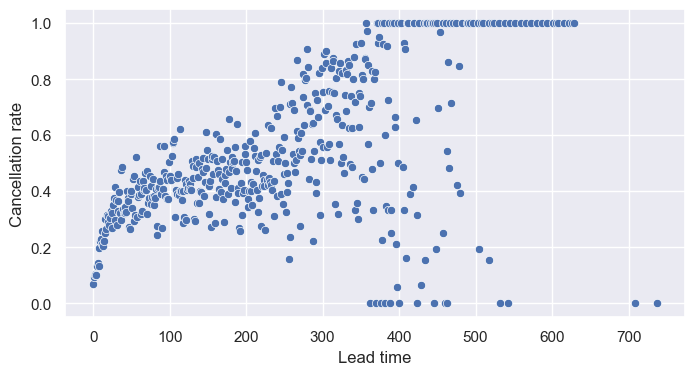

In [27]:
cancel_rates = df.groupby('lead_time')['is_canceled'].mean()

plt.figure(figsize=(8,4))
sns.scatterplot(x=cancel_rates.index, y=cancel_rates.values)
plt.xlabel("Lead time")
plt.ylabel("Cancellation rate")
plt.show()

- As we can  see the Cancellation rate slightly increase with the increase in Lead time

# Where do the guests come from?

- Countries from which guest didn't cancel the booking

In [22]:
country_wise_data_0 = df[df['is_canceled']==0]['country'].value_counts().reset_index()
country_wise_data_0.columns = ['country', 'No of guests']
country_wise_data_0

country  No of guests
0       PRT         20977
1       GBR          9667
2       FRA          8468
3       ESP          6383
4       DEU          6067
..      ...           ...
160     BHR             1
161     DJI             1
162     MLI             1
163     NPL             1
164     FRO             1

[165 rows x 2 columns]

- Countries from which guest did cancel the booking

In [23]:
country_wise_data_1 = df[df['is_canceled']==1]['country'].value_counts().reset_index()
country_wise_data_1.columns = ['country', 'No of guests']
country_wise_data_1

country  No of guests
0       PRT         27501
1       GBR          2452
2       ESP          2177
3       FRA          1933
4       ITA          1333
..      ...           ...
122     UMI             1
123     HND             1
124     FJI             1
125     SYC             1
126     CRI             1

[127 rows x 2 columns]

In [24]:
basemap = folium.Map()

In [25]:
map_guest_0 = px.choropleth(country_wise_data_0,
                           locations = country_wise_data_0['country'],
                            locationmode='ISO-3',
                           color = country_wise_data_0['No of guests'],
                           hover_name = country_wise_data_0['country'],
                            range_color=[0, 12000])
map_guest_0.show()
#,title="Home country of guests"

- Very large portion of guest who didn't cancel the bookings are from Portugal(PRT), followed by few other European Countries

In [26]:
map_guest_1 = px.choropleth(country_wise_data_1,
                           locations = country_wise_data_1['country'],
                            locationmode='ISO-3',
                           color = country_wise_data_1['No of guests'],
                           hover_name = country_wise_data_1['country'],
                            range_color=[0, 4000])
map_guest_1.show()

- Again Portugal(PRT) is top for the people those who canceled their bookings followed by few European Countries.
- It seems like most of the guests are from European Countries, mainly from Portugal

- From the graph it is clear that people from some countries didn't canceled their bookings even once. Maybe they are newcomers

In [28]:
df0 = df[df['is_canceled']==0]

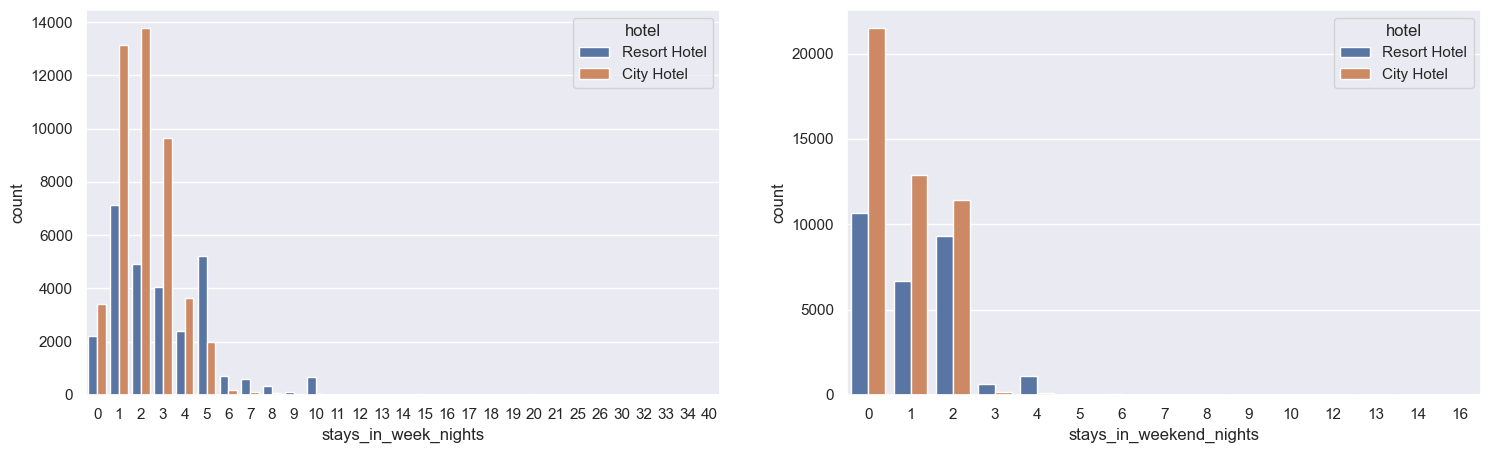

In [29]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (18,5))

sns.countplot(df0, x = df0['stays_in_week_nights'], hue = df0['hotel'], ax=ax1)

sns.countplot(df0, x = df0['stays_in_weekend_nights'], hue = df0['hotel'], ax=ax2)

plt.show()

- For week nights, most people choose to stay 2 nights in City hotel. In case of Resort hotel it is 1 nights.
- For weekend nights, most people choose to stay 1 night in City hotel. In case of Resort hotel it is 2 nights.

Text(0, 0.5, 'Cancellation Count')

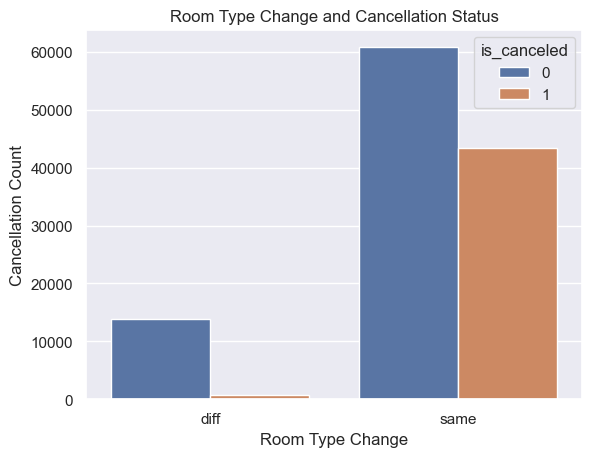

In [30]:
df['room_change'] = np.where(df['reserved_room_type'] == df['assigned_room_type'], 'same', 'diff')

counts = df.groupby(['room_change', 'is_canceled']).size().reset_index(name='count')

sns.barplot(x='room_change', y=counts['count'], hue='is_canceled', data=counts)

plt.title('Room Type Change and Cancellation Status')
plt.xlabel('Room Type Change')
plt.ylabel('Cancellation Count')

- Change in rooms has no major effect on cancellation

In [31]:
df.drop(columns = ['room_change'], inplace = True)

# Price for a room per night

In [32]:
print('reserved_room_type:', df['reserved_room_type'].unique())

reserved_room_type: ['C' 'A' 'D' 'E' 'G' 'F' 'H' 'L' 'B']


- Both hotels have different types of rooms. so, price may vary a lot

In [33]:
px.box(data_frame = df0, x = 'reserved_room_type', y = 'adr', color = 'hotel')

- The figure shows that the average price per room depends on its type
- In case of Resort hotel room 'H' has high average daily rate and in case of City hotel it seems to be room type 'G' has high adr
- Resort Hotel has more Room types than that of City Hotel

# Customer Types

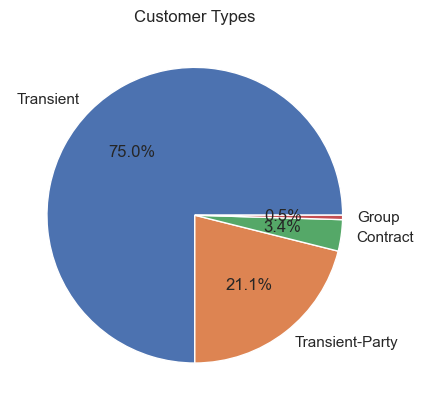

In [76]:
customer_counts = df['customer_type'].value_counts()
customer_types = customer_counts.index.tolist()

plt.pie(customer_counts, labels=customer_types, autopct='%1.1f%%')

plt.title('Customer Types')
plt.show()

# Market Segments

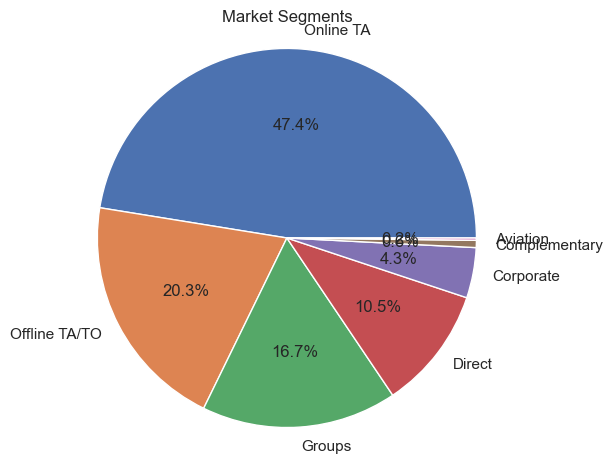

In [79]:
market_segment_counts = df['market_segment'].value_counts()
market_segments = market_segment_counts.index.tolist()

plt.pie(market_segment_counts, labels=market_segments, autopct='%1.1f%%')

plt.title('Market Segments')
plt.axis('equal')
plt.tight_layout()
plt.show()

# Which are the most busy months?

In [38]:
resort_guest = data_resort['arrival_date_month'].value_counts().reset_index()
resort_guest.columns = ['Month', 'No of guest in Resort']

city_guest = data_city['arrival_date_month'].value_counts().reset_index()
city_guest.columns = ['Month', 'No of guest in City']

final_guests = resort_guest.merge(city_guest, on = 'Month')
final_guests = sd.Sort_Dataframeby_Month(final_guests, 'Month')

final_guests

Month  No of guest in Resort  No of guest in City
0     January                   1812                 2249
1    February                   2253                 3051
2       March                   2516                 4049
3       April                   2518                 4010
4         May                   2523                 4568
5        June                   2026                 4358
6        July                   3110                 4770
7      August                   3237                 5367
8   September                   2077                 4283
9     October                   2528                 4326
10   November                   1937                 2674
11   December                   1970                 2377

In [39]:
plt.figure(figsize=(15,6))

px.line(final_guests, x = 'Month', y = ['No of guest in Resort', 'No of guest in City'],
        title = 'Total no of guest per month')

<Figure size 1500x600 with 0 Axes>

- Both hotels has large number of guest during July-August, when the prices are also almost highest.
- Both hotels has low number of guests from November-February, when the prices are also lowest.

# Data Preprocessing

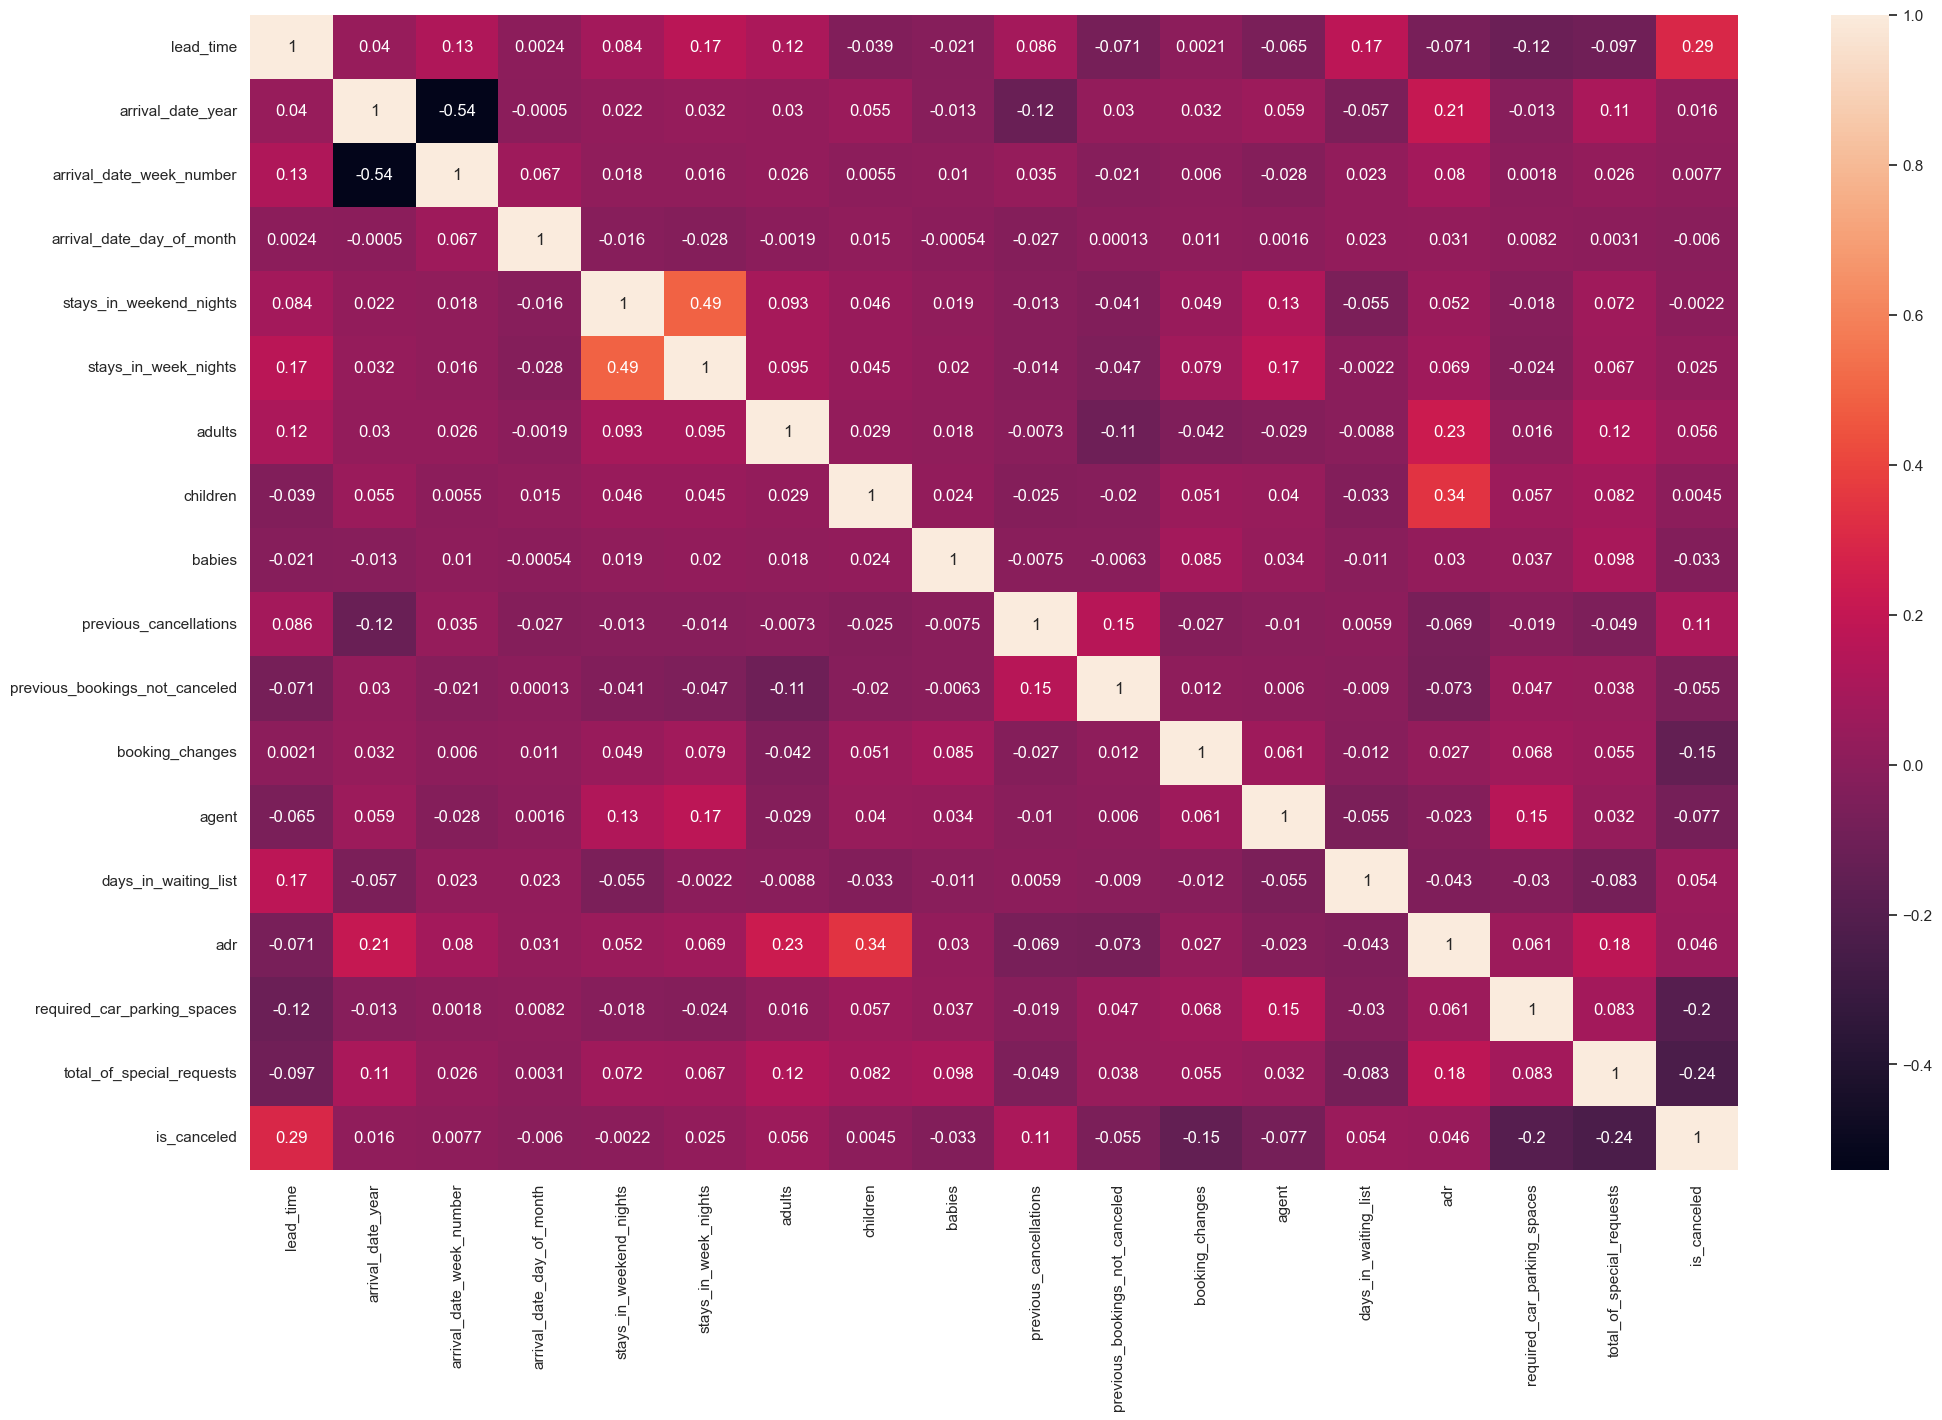

In [40]:
plt.figure(figsize=(24,15))

corr = df.corr()
sns.heatmap(corr, annot = True)
plt.show()

- Since, reservation_status, reservation_status_date and booking_changes cannot be obtained from booking information it is better to remove those features from dataset for prediction.

In [41]:
df.drop(columns = ['reservation_status', 'reservation_status_date', 'booking_changes'], inplace = True)

- If the guest is not a repeated guest i.e, if it's a new guest then 'previous_cancellations' and 'previous_bookings_not_canceled' can only be 0 (since, it's there first time). So, correcting the error part by making both 0

In [42]:
err1 = df[(df['is_repeated_guest']==0)&(df['previous_cancellations']!=0)]
len(err1)

5520

In [43]:
err2 = df[(df['is_repeated_guest']==0)&(df['previous_bookings_not_canceled']!=0)]
len(err2)

560

In [44]:
df.loc[df['is_repeated_guest'] == 0, ['previous_cancellations', 'previous_bookings_not_canceled']] = 0

- Separating the dataset into numerical and categorical columns

In [45]:
  num_features = df.select_dtypes(exclude = ['object']).columns
print(f"Number of numerical features are: {len(num_features)}")
print(num_features)
print('\n')
cat_features = df.select_dtypes(include = ['object']).columns
print(f"Number of categorical features are: {len(cat_features)}")
print(cat_features)

Number of numerical features are: 17
Index(['lead_time', 'arrival_date_year', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies',
       'previous_cancellations', 'previous_bookings_not_canceled', 'agent',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'is_canceled'],
      dtype='object')


Number of categorical features are: 11
Index(['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment',
       'distribution_channel', 'is_repeated_guest', 'reserved_room_type',
       'assigned_room_type', 'deposit_type', 'customer_type'],
      dtype='object')


In [46]:
num_features = num_features.drop('is_canceled')

In [47]:
corr = df[num_features].corrwith(df['is_canceled']).abs().sort_values(ascending = False)
corr

lead_time                         0.291619
total_of_special_requests         0.235923
required_car_parking_spaces       0.195013
agent                             0.077239
adults                            0.056129
days_in_waiting_list              0.054114
previous_bookings_not_canceled    0.052751
adr                               0.045910
babies                            0.032605
stays_in_week_nights              0.024825
arrival_date_year                 0.016419
arrival_date_week_number          0.007668
arrival_date_day_of_month         0.006022
children                          0.004536
previous_cancellations            0.002262
stays_in_weekend_nights           0.002192
dtype: float64

In [48]:
df_num_features = df[num_features]

- Combining 'adults', 'children' and 'babies' into one single column 'total_guest' may increase performance

In [49]:
df_num_features['total_guest'] = df_num_features['adults'] + df_num_features['children'] + df_num_features['babies']
df_num_features.drop(columns = ['adults', 'children', 'babies'], inplace = True)

#df_num_features['total_stays'] = df_num_features['stays_in_week_nights'] + df_num_features['stays_in_weekend_nights']
#df_num_features.drop(columns = ['stays_in_week_nights', 'stays_in_weekend_nights'], inplace = True)

In [50]:
y = df['is_canceled']
etr = ExtraTreesRegressor()
etr.fit(df_num_features,y)

imp_data = pd.DataFrame({"feature" : df_num_features.columns, 
                         "importances" : etr.feature_importances_}).sort_values(by = 'importances',ascending = False)

fig = px.bar(imp_data,x = 'feature',y = 'importances', color_discrete_sequence = ['#1f77b4'])
fig.show()

- 'arrival_date_year' is not important, because while predicting present year matters and data has past years. So,removing it.
- removing 'previous_bookings_not_canceled' since, it has least importance but keeping 'previous_cancellations'

In [51]:
df_num_features.drop(columns = [ 'arrival_date_year','previous_bookings_not_canceled'], inplace = True)

In [52]:
v = df_num_features
vif_data = pd.DataFrame()

vif_data['Feature'] = v.columns
vif_data['VIF'] = [vif(v.values,i) for i in range(len(v.columns))]

vif_data = vif_data.sort_values(by = ['VIF'], ascending = False)
vif_data

Feature       VIF
11                  total_guest  8.167980
8                           adr  6.332487
1      arrival_date_week_number  4.377731
4          stays_in_week_nights  3.720697
2     arrival_date_day_of_month  3.621785
3       stays_in_weekend_nights  2.495333
0                     lead_time  2.154010
6                         agent  1.770451
10    total_of_special_requests  1.622191
9   required_car_parking_spaces  1.114042
7          days_in_waiting_list  1.058936
5        previous_cancellations  1.002959

- Data has low VIF which reduces the chances of Multicollinearity

In [53]:
chi_2 = pd.DataFrame(columns=['Feature', 'Chi-square statistic', 'P-value'])

for feature in cat_features:
    contingency_table = pd.crosstab(df[feature], df['is_canceled'])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    
    chi_2 = chi_2.append({'Feature': feature,
               'Chi-square statistic': chi2,
                'P-value': p}, ignore_index = True)

chi_2 = chi_2.sort_values('Chi-square statistic', ascending=False, ignore_index = True)
print(chi_2)

                 Feature  Chi-square statistic        P-value
0           deposit_type          27506.486251   0.000000e+00
1                country          15468.393325   0.000000e+00
2         market_segment           8382.298439   0.000000e+00
3     assigned_room_type           4785.365652   0.000000e+00
4   distribution_channel           3638.342957   0.000000e+00
5          customer_type           2259.584663   0.000000e+00
6                  hotel           2147.690942   0.000000e+00
7      is_repeated_guest            839.026741  1.766828e-184
8     reserved_room_type            638.521705  1.216597e-132
9     arrival_date_month            555.379873  4.842015e-112
10                  meal            304.903440   9.484864e-65


In [54]:
for col in cat_features:
    print(f"{col}: \n{df[col].unique()}\n")

hotel: 
['Resort Hotel' 'City Hotel']

arrival_date_month: 
['July' 'August' 'September' 'October' 'November' 'December' 'January'
 'February' 'March' 'April' 'May' 'June']

meal: 
['BB' 'FB' 'HB' 'SC' 'Undefined']

country: 
['PRT' 'GBR' 'USA' 'ESP' 'IRL' 'FRA' 'ROU' 'NOR' 'OMN' 'ARG' 'POL' 'DEU'
 'BEL' 'CHE' 'CN' 'GRC' 'ITA' 'NLD' 'DNK' 'RUS' 'SWE' 'AUS' 'EST' 'CZE'
 'BRA' 'FIN' 'MOZ' 'BWA' 'LUX' 'SVN' 'ALB' 'IND' 'CHN' 'MEX' 'MAR' 'UKR'
 'SMR' 'LVA' 'PRI' 'SRB' 'CHL' 'AUT' 'BLR' 'LTU' 'TUR' 'ZAF' 'AGO' 'ISR'
 'CYM' 'ZMB' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN' 'ARE' 'TUN' 'JAM' 'HRV'
 'HKG' 'IRN' 'GEO' 'AND' 'GIB' 'URY' 'JEY' 'CAF' 'CYP' 'COL' 'GGY' 'KWT'
 'NGA' 'MDV' 'VEN' 'SVK' 'FJI' 'KAZ' 'PAK' 'IDN' 'LBN' 'PHL' 'SEN' 'SYC'
 'AZE' 'BHR' 'NZL' 'THA' 'DOM' 'MKD' 'MYS' 'ARM' 'JPN' 'LKA' 'CUB' 'CMR'
 'BIH' 'MUS' 'COM' 'SUR' 'UGA' 'BGR' 'CIV' 'JOR' 'SYR' 'SGP' 'BDI' 'SAU'
 'VNM' 'PLW' 'QAT' 'EGY' 'PER' 'MLT' 'MWI' 'ECU' 'MDG' 'ISL' 'UZB' 'NPL'
 'BHS' 'MAC' 'TGO' 'TWN' 'DJI' 'STP' 'KNA' 'E

In [55]:
df_cat_features = df[cat_features]

- removing 'reserved_room_type' since 'assigned_room_type' is all that matters

In [56]:
#df_cat_features.drop(columns = ['country', 'reserved_room_type'], inplace = True)
df_cat_features.drop(columns = ['reserved_room_type'], inplace = True)

In [57]:
le = LabelEncoder()

df_cat_features['hotel'] = le.fit_transform(df_cat_features['hotel'])

ordinal_encoder = OrdinalEncoder(categories=[['January', 'February', 'March', 'April', 'May', 'June',
                                              'July', 'August', 'September', 'October', 'November', 'December']])
df_cat_features['arrival_date_month'] = ordinal_encoder.fit_transform(df_cat_features[['arrival_date_month']])

df_cat_features['meal'] = le.fit_transform(df_cat_features['meal'])

dummy_market = pd.get_dummies(df_cat_features['market_segment'], prefix='market', drop_first=True)
df_cat_features = pd.concat([df_cat_features, dummy_market], axis=1)
df_cat_features.drop(columns='market_segment', inplace=True)

dummy_dist = pd.get_dummies(df_cat_features['distribution_channel'], prefix='channel', drop_first=True)
df_cat_features = pd.concat([df_cat_features, dummy_dist], axis=1)
df_cat_features.drop(columns='distribution_channel', inplace=True)

df_cat_features['is_repeated_guest'] = le.fit_transform(df_cat_features['is_repeated_guest'])

ordinal_encoder = OrdinalEncoder(categories=[['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L']])
df_cat_features['assigned_room_type'] = ordinal_encoder.fit_transform(df_cat_features[['assigned_room_type']])

dummy_deposit = pd.get_dummies(df_cat_features['deposit_type'], prefix='deposit_type')
df_cat_features = pd.concat([df_cat_features, dummy_deposit], axis=1)
df_cat_features.drop(columns='deposit_type', inplace=True)

df_cat_features['customer_type'] = le.fit_transform(df_cat_features['customer_type'])

df_cat_features['country'] = le.fit_transform(df_cat_features['country'])

**Train Test split**

In [58]:
data = pd.concat([df_num_features, df_cat_features, df['is_canceled']], axis=1)

In [59]:
X = data.drop(columns=['is_canceled'])
Y = data['is_canceled']

In [60]:
X.shape, Y.shape

((118726, 32), (118726,))

In [61]:
round(data['is_canceled'].value_counts()/data.shape[0],2)

0    0.63
1    0.37
Name: is_canceled, dtype: float64

In [62]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.30)

In [63]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

**Logistic Regression**

In [72]:
lr = LogisticRegression()
lr.fit(X_train, Y_train)

Y_pred_lr = lr.predict(X_test)

acc_lr = accuracy_score(Y_test, Y_pred_lr)
conf = confusion_matrix(Y_test, Y_pred_lr)
clf_report = classification_report(Y_test, Y_pred_lr)

print(f"Accuracy Score of Logistic Regression is : {acc_lr}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Logistic Regression is : 0.7876975771357984
Confusion Matrix : 
[[20290  2046]
 [ 5516  7767]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.79      0.91      0.84     22336
           1       0.79      0.58      0.67     13283

    accuracy                           0.79     35619
   macro avg       0.79      0.75      0.76     35619
weighted avg       0.79      0.79      0.78     35619



**KNN**

In [65]:
knn = KNeighborsClassifier()
knn.fit(X_train, Y_train)

Y_pred_knn = knn.predict(X_test)

acc_knn = accuracy_score(Y_test, Y_pred_knn)
conf = confusion_matrix(Y_test, Y_pred_knn)
clf_report = classification_report(Y_test, Y_pred_knn)

print(f"Accuracy Score of KNN is : {acc_knn}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of KNN is : 0.8276994777921276
Confusion Matrix : 
[[19598  2686]
 [ 3451  9883]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.85      0.88      0.86     22284
           1       0.79      0.74      0.76     13334

    accuracy                           0.83     35618
   macro avg       0.82      0.81      0.81     35618
weighted avg       0.83      0.83      0.83     35618



**Decision Tree**

In [66]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, Y_train)

Y_pred_dtc = dtc.predict(X_test)

acc_dtc = accuracy_score(Y_test, Y_pred_dtc)
conf = confusion_matrix(Y_test, Y_pred_dtc)
clf_report = classification_report(Y_test, Y_pred_dtc)

print(f"Accuracy Score of Decision Tree is : {acc_dtc}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Decision Tree is : 0.8417373238250323
Confusion Matrix : 
[[19370  2914]
 [ 2723 10611]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.88      0.87      0.87     22284
           1       0.78      0.80      0.79     13334

    accuracy                           0.84     35618
   macro avg       0.83      0.83      0.83     35618
weighted avg       0.84      0.84      0.84     35618



**Random Forest**

In [67]:
rd_clf = RandomForestClassifier()
rd_clf.fit(X_train, Y_train)

Y_pred_rd_clf = rd_clf.predict(X_test)

acc_rd_clf = accuracy_score(Y_test, Y_pred_rd_clf)
conf = confusion_matrix(Y_test, Y_pred_rd_clf)
clf_report = classification_report(Y_test, Y_pred_rd_clf)

print(f"Accuracy Score of Random Forest is : {acc_rd_clf}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Random Forest is : 0.8836543320792858
Confusion Matrix : 
[[20751  1533]
 [ 2611 10723]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.89      0.93      0.91     22284
           1       0.87      0.80      0.84     13334

    accuracy                           0.88     35618
   macro avg       0.88      0.87      0.87     35618
weighted avg       0.88      0.88      0.88     35618



**Ada Boost**

In [68]:
ada = AdaBoostClassifier(base_estimator = dtc)
ada.fit(X_train, Y_train)

Y_pred_ada = ada.predict(X_test)

acc_ada = accuracy_score(Y_test, Y_pred_ada)
conf = confusion_matrix(Y_test, Y_pred_ada)
clf_report = classification_report(Y_test, Y_pred_ada)

print(f"Accuracy Score of Ada Boost Classifier is : {acc_ada}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Ada Boost Classifier is : 0.8542590824863833
Confusion Matrix : 
[[20494  1790]
 [ 3401  9933]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.86      0.92      0.89     22284
           1       0.85      0.74      0.79     13334

    accuracy                           0.85     35618
   macro avg       0.85      0.83      0.84     35618
weighted avg       0.85      0.85      0.85     35618



**Gradient Boost**

In [69]:
gb = GradientBoostingClassifier()
gb.fit(X_train, Y_train)

Y_pred_gb = gb.predict(X_test)

acc_gb = accuracy_score(Y_test, Y_pred_gb)
conf = confusion_matrix(Y_test, Y_pred_gb)
clf_report = classification_report(Y_test, Y_pred_gb)

print(f"Accuracy Score of Ada Boost Classifier is : {acc_gb}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Ada Boost Classifier is : 0.8341568869672638
Confusion Matrix : 
[[20248  2036]
 [ 3871  9463]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.84      0.91      0.87     22284
           1       0.82      0.71      0.76     13334

    accuracy                           0.83     35618
   macro avg       0.83      0.81      0.82     35618
weighted avg       0.83      0.83      0.83     35618



**XgBoost**

In [70]:
xgb = XGBClassifier(booster = 'gbtree', learning_rate = 0.1, max_depth = 5, n_estimators = 180)
xgb.fit(X_train, Y_train)

Y_pred_xgb = xgb.predict(X_test)

acc_xgb = accuracy_score(Y_test, Y_pred_xgb)
conf = confusion_matrix(Y_test, Y_pred_xgb)
clf_report = classification_report(Y_test, Y_pred_xgb)

print(f"Accuracy Score of Ada Boost Classifier is : {acc_xgb}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Ada Boost Classifier is : 0.8574316356898197
Confusion Matrix : 
[[20300  1984]
 [ 3094 10240]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.87      0.91      0.89     22284
           1       0.84      0.77      0.80     13334

    accuracy                           0.86     35618
   macro avg       0.85      0.84      0.85     35618
weighted avg       0.86      0.86      0.86     35618



**Cat Boost**

In [71]:
cat = CatBoostClassifier(iterations=100)
cat.fit(X_train, Y_train)

Y_pred_cat = cat.predict(X_test)

acc_cat = accuracy_score(Y_test, Y_pred_cat)
conf = confusion_matrix(Y_test, Y_pred_cat)
clf_report = classification_report(Y_test, Y_pred_cat)

Learning rate set to 0.5
0:	learn: 0.4411171	total: 189ms	remaining: 18.7s
1:	learn: 0.4004393	total: 217ms	remaining: 10.6s
2:	learn: 0.3793122	total: 246ms	remaining: 7.95s
3:	learn: 0.3713343	total: 275ms	remaining: 6.6s
4:	learn: 0.3668294	total: 302ms	remaining: 5.73s
5:	learn: 0.3577883	total: 328ms	remaining: 5.14s
6:	learn: 0.3534060	total: 353ms	remaining: 4.69s
7:	learn: 0.3493555	total: 379ms	remaining: 4.36s
8:	learn: 0.3401896	total: 406ms	remaining: 4.11s
9:	learn: 0.3337958	total: 434ms	remaining: 3.91s
10:	learn: 0.3319857	total: 459ms	remaining: 3.71s
11:	learn: 0.3296531	total: 484ms	remaining: 3.55s
12:	learn: 0.3270652	total: 506ms	remaining: 3.39s
13:	learn: 0.3259241	total: 530ms	remaining: 3.25s
14:	learn: 0.3246614	total: 553ms	remaining: 3.13s
15:	learn: 0.3230505	total: 575ms	remaining: 3.02s
16:	learn: 0.3207394	total: 598ms	remaining: 2.92s
17:	learn: 0.3201790	total: 623ms	remaining: 2.84s
18:	learn: 0.3191536	total: 649ms	remaining: 2.77s
19:	learn: 0.3176

In [72]:
print(f"Accuracy Score of Cat Boost Classifier is : {acc_cat}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Cat Boost Classifier is : 0.863580212252232
Confusion Matrix : 
[[20221  2063]
 [ 2796 10538]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.88      0.91      0.89     22284
           1       0.84      0.79      0.81     13334

    accuracy                           0.86     35618
   macro avg       0.86      0.85      0.85     35618
weighted avg       0.86      0.86      0.86     35618



# Model Evaluation

In [73]:
cv_scores_lr = cross_val_score(lr, X_train, Y_train, cv = 5, scoring = 'accuracy')
cv_scores_knn = cross_val_score(knn, X_train, Y_train, cv = 5, scoring = 'accuracy')
cv_scores_dt = cross_val_score(dtc, X_train, Y_train, cv = 5, scoring = 'accuracy')
cv_scores_rf = cross_val_score(rd_clf, X_train, Y_train, cv = 5, scoring = 'accuracy')
cv_scores_adb = cross_val_score(ada, X_train, Y_train, cv = 5, scoring = 'accuracy')
cv_scores_gdb = cross_val_score(gb, X_train, Y_train, cv = 5, scoring = 'accuracy')
cv_scores_xgb = cross_val_score(xgb, X_train, Y_train, cv = 5, scoring = 'accuracy')
cv_scores_cat = cross_val_score(cat, X_train, Y_train, cv = 5, scoring = 'accuracy')

Learning rate set to 0.5
0:	learn: 0.4402682	total: 17.2ms	remaining: 1.7s
1:	learn: 0.3974508	total: 33.9ms	remaining: 1.66s
2:	learn: 0.3788355	total: 48.4ms	remaining: 1.56s
3:	learn: 0.3684983	total: 63.1ms	remaining: 1.51s
4:	learn: 0.3621858	total: 77.5ms	remaining: 1.47s
5:	learn: 0.3576621	total: 91ms	remaining: 1.43s
6:	learn: 0.3534655	total: 105ms	remaining: 1.39s
7:	learn: 0.3505956	total: 118ms	remaining: 1.36s
8:	learn: 0.3445508	total: 134ms	remaining: 1.35s
9:	learn: 0.3404219	total: 148ms	remaining: 1.33s
10:	learn: 0.3387961	total: 164ms	remaining: 1.33s
11:	learn: 0.3371993	total: 180ms	remaining: 1.32s
12:	learn: 0.3352129	total: 196ms	remaining: 1.31s
13:	learn: 0.3345667	total: 212ms	remaining: 1.3s
14:	learn: 0.3339261	total: 232ms	remaining: 1.31s
15:	learn: 0.3322676	total: 247ms	remaining: 1.3s
16:	learn: 0.3311718	total: 263ms	remaining: 1.28s
17:	learn: 0.3297345	total: 276ms	remaining: 1.26s
18:	learn: 0.3283784	total: 291ms	remaining: 1.24s
19:	learn: 0.32

65:	learn: 0.2785100	total: 1.06s	remaining: 547ms
66:	learn: 0.2777829	total: 1.08s	remaining: 531ms
67:	learn: 0.2773695	total: 1.09s	remaining: 515ms
68:	learn: 0.2767925	total: 1.11s	remaining: 498ms
69:	learn: 0.2763330	total: 1.12s	remaining: 482ms
70:	learn: 0.2758192	total: 1.14s	remaining: 465ms
71:	learn: 0.2754618	total: 1.15s	remaining: 448ms
72:	learn: 0.2750887	total: 1.17s	remaining: 432ms
73:	learn: 0.2746266	total: 1.18s	remaining: 415ms
74:	learn: 0.2741282	total: 1.2s	remaining: 399ms
75:	learn: 0.2735587	total: 1.21s	remaining: 383ms
76:	learn: 0.2731638	total: 1.23s	remaining: 366ms
77:	learn: 0.2727720	total: 1.24s	remaining: 350ms
78:	learn: 0.2719990	total: 1.26s	remaining: 334ms
79:	learn: 0.2717480	total: 1.27s	remaining: 318ms
80:	learn: 0.2712715	total: 1.29s	remaining: 302ms
81:	learn: 0.2707201	total: 1.3s	remaining: 286ms
82:	learn: 0.2704304	total: 1.32s	remaining: 270ms
83:	learn: 0.2698643	total: 1.33s	remaining: 254ms
84:	learn: 0.2694205	total: 1.35s

26:	learn: 0.3096279	total: 424ms	remaining: 1.15s
27:	learn: 0.3089251	total: 440ms	remaining: 1.13s
28:	learn: 0.3077417	total: 457ms	remaining: 1.12s
29:	learn: 0.3071922	total: 473ms	remaining: 1.1s
30:	learn: 0.3064917	total: 488ms	remaining: 1.08s
31:	learn: 0.3055434	total: 502ms	remaining: 1.07s
32:	learn: 0.3045100	total: 517ms	remaining: 1.05s
33:	learn: 0.3032821	total: 532ms	remaining: 1.03s
34:	learn: 0.3019117	total: 547ms	remaining: 1.02s
35:	learn: 0.3009850	total: 563ms	remaining: 1s
36:	learn: 0.3006793	total: 577ms	remaining: 983ms
37:	learn: 0.3005684	total: 594ms	remaining: 970ms
38:	learn: 0.3000436	total: 611ms	remaining: 956ms
39:	learn: 0.2988217	total: 629ms	remaining: 943ms
40:	learn: 0.2980976	total: 648ms	remaining: 933ms
41:	learn: 0.2974136	total: 668ms	remaining: 922ms
42:	learn: 0.2965971	total: 686ms	remaining: 910ms
43:	learn: 0.2956183	total: 704ms	remaining: 895ms
44:	learn: 0.2946790	total: 722ms	remaining: 882ms
45:	learn: 0.2941261	total: 739ms	r

91:	learn: 0.2645048	total: 1.51s	remaining: 131ms
92:	learn: 0.2638928	total: 1.52s	remaining: 115ms
93:	learn: 0.2635082	total: 1.54s	remaining: 98.5ms
94:	learn: 0.2631041	total: 1.56s	remaining: 82.2ms
95:	learn: 0.2628810	total: 1.58s	remaining: 65.8ms
96:	learn: 0.2625894	total: 1.59s	remaining: 49.3ms
97:	learn: 0.2620621	total: 1.61s	remaining: 32.8ms
98:	learn: 0.2617905	total: 1.62s	remaining: 16.4ms
99:	learn: 0.2612650	total: 1.64s	remaining: 0us


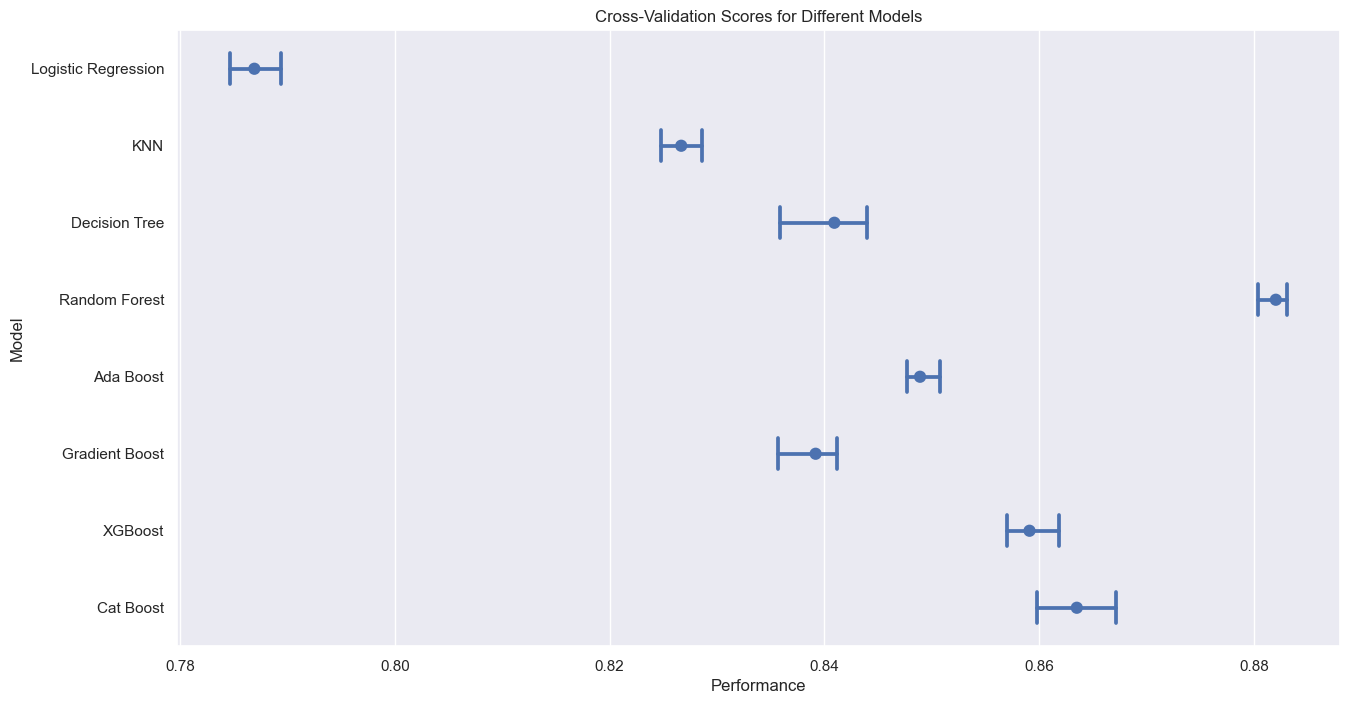

In [82]:
model_names = ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'Ada Boost', 'Gradient Boost', 'XGBoost', 'Cat Boost']

cv_scores = np.concatenate([cv_scores_lr, 
                            cv_scores_knn, 
                            cv_scores_dt, 
                            cv_scores_rf, 
                            cv_scores_adb, 
                            cv_scores_gdb,
                            cv_scores_xgb, 
                            cv_scores_cat])


models = np.repeat(model_names, len(cv_scores_lr))


fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = [15,8])
sns.pointplot( x = cv_scores, y = models, join = False, errorbar = ('ci', 100), capsize = .4, ax = ax)


plt.xlabel('Performance')
plt.ylabel('Model')
plt.title('Cross-Validation Scores for Different Models')

plt.show()

In [83]:
print('-------------Logistic Regression-----------')

log_prec = precision_score(Y_test,Y_pred_lr,average='macro')
print(f'Precision : {log_prec:1.2f}')
log_rec = recall_score(Y_test,Y_pred_lr,average='macro')
print(f'Recall : {log_rec:1.2f}')
log_f1 = f1_score(Y_test,Y_pred_lr,average='macro')
print(f'F1 Score : {log_f1:1.2f}')
log_acc = accuracy_score(Y_test,Y_pred_lr)
print(f'Accuracy : {log_acc:1.2f}')

print()
print('-------------------KNN--------------------')

knn_prec = precision_score(Y_test,Y_pred_knn,average='macro')
print(f'Precision : {knn_prec:1.2f}')
knn_rec = recall_score(Y_test,Y_pred_knn,average='macro')
print(f'Recall : {knn_rec:1.2f}')
knn_f1 = f1_score(Y_test,Y_pred_knn,average='macro')
print(f'F1 Score : {knn_f1:1.2f}')
knn_acc = accuracy_score(Y_test,Y_pred_knn)
print(f'Accuracy : {knn_acc:1.2f}')

print()
print('---------------Decision Tree-------------')

dt_prec = precision_score(Y_test,Y_pred_dtc, average='macro')
print(f'Precision : {dt_prec:1.2f}')
dt_rec = recall_score(Y_test,Y_pred_dtc, average='macro')
print(f'Recall : {dt_rec:1.2f}')
dt_f1 = f1_score(Y_test,Y_pred_dtc, average='macro')
print(f'F1 Score : {dt_f1:1.2f}')
dt_acc = accuracy_score(Y_test,Y_pred_dtc)
print(f'Accuracy : {dt_acc:1.2f}')

print()
print('---------------Random Forest-------------')

rf_prec = precision_score(Y_test,Y_pred_rd_clf, average='macro')
print(f'Precision : {rf_prec:1.2f}')
rf_rec = recall_score(Y_test,Y_pred_rd_clf, average='macro')
print(f'Recall : {rf_rec:1.2f}')
rf_f1 = f1_score(Y_test,Y_pred_rd_clf, average='macro')
print(f'F1 Score : {rf_f1:1.2f}')
rf_acc = accuracy_score(Y_test,Y_pred_rd_clf)
print(f'Accuracy : {rf_acc:1.2f}')

print()
print('------------------Ada Boost----------------')

ab_prec = precision_score(Y_test,Y_pred_ada, average='macro')
print(f'Precision : {ab_prec:1.2f}')
ab_rec = recall_score(Y_test,Y_pred_ada, average='macro')
print(f'Recall : {ab_rec:1.2f}')
ab_f1 = f1_score(Y_test,Y_pred_ada, average='macro')
print(f'F1 Score : {ab_f1:1.2f}')
ab_acc = accuracy_score(Y_test,Y_pred_ada)
print(f'Accuracy : {ab_acc:1.2f}')

print()
print('---------------Gradient Boost---------------')

gb_prec = precision_score(Y_test,Y_pred_gb, average='macro')
print(f'Precision : {gb_prec:1.2f}')
gb_rec = recall_score(Y_test,Y_pred_gb, average='macro')
print(f'Recall : {gb_rec:1.2f}')
gb_f1 = f1_score(Y_test,Y_pred_gb, average='macro')
print(f'F1 Score : {gb_f1:1.2f}')
gb_acc = accuracy_score(Y_test,Y_pred_gb)
print(f'Accuracy : {gb_acc:1.2f}')

print()
print('-------------Xtreme Gradient Boost-----------')

xg_prec = precision_score(Y_test,Y_pred_xgb, average='macro')
print(f'Precision : {xg_prec:1.2f}')
xg_rec = recall_score(Y_test,Y_pred_xgb, average='macro')
print(f'Recall : {xg_rec:1.2f}')
xg_f1 = f1_score(Y_test,Y_pred_xgb, average='macro')
print(f'F1 Score : {xg_f1:1.2f}')
xg_acc = accuracy_score(Y_test,Y_pred_xgb)
print(f'Accuracy : {xg_acc:1.2f}')

print()
print('-----------------Cat Boost-----------------')

cat_prec = precision_score(Y_test,Y_pred_cat, average='macro')
print(f'Precision : {cat_prec:1.2f}')
cat_rec = recall_score(Y_test,Y_pred_cat, average='macro')
print(f'Recall : {cat_rec:1.2f}')
cat_f1 = f1_score(Y_test,Y_pred_cat, average='macro')
print(f'F1 Score : {cat_f1:1.2f}')
cat_acc = accuracy_score(Y_test,Y_pred_cat)
print(f'Accuracy : {cat_acc:1.2f}')

-------------Logistic Regression-----------
Precision : 0.79
Recall : 0.75
F1 Score : 0.76
Accuracy : 0.79

-------------------KNN--------------------
Precision : 0.82
Recall : 0.81
F1 Score : 0.81
Accuracy : 0.83

---------------Decision Tree-------------
Precision : 0.83
Recall : 0.83
F1 Score : 0.83
Accuracy : 0.84

---------------Random Forest-------------
Precision : 0.88
Recall : 0.87
F1 Score : 0.87
Accuracy : 0.88

------------------Ada Boost----------------
Precision : 0.84
Recall : 0.84
F1 Score : 0.84
Accuracy : 0.85

---------------Gradient Boost---------------
Precision : 0.83
Recall : 0.81
F1 Score : 0.82
Accuracy : 0.84

-------------Xtreme Gradient Boost-----------
Precision : 0.85
Recall : 0.84
F1 Score : 0.85
Accuracy : 0.86

-----------------Cat Boost-----------------
Precision : 0.86
Recall : 0.85
F1 Score : 0.85
Accuracy : 0.86


In [84]:
result = pd.DataFrame({'Precision' : [log_prec, knn_prec, dt_prec, rf_prec, ab_prec, gb_prec, xg_prec, cat_prec],
                     'Recall' : [log_rec, knn_rec, dt_rec, rf_rec, ab_rec, gb_rec, xg_rec, cat_rec],
                     'F1 Score' : [log_f1, knn_f1, dt_f1, rf_f1, ab_f1, gb_f1, xg_f1, cat_f1],
                     'Accuracy' : [log_acc, knn_acc, dt_acc, rf_acc, ab_acc, gb_acc, xg_acc, cat_acc]}, 
                     index = ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'Ada Boost', 'Gradient Boost', 'Xtreme Gradient Boost', 'Cat Boost'])

In [85]:
result.sort_values(by = ('Accuracy'), ascending = False)

Precision    Recall  F1 Score  Accuracy
Random Forest           0.882964  0.868431  0.874635  0.884837
Cat Boost               0.858715  0.849595  0.853666  0.864791
Xtreme Gradient Boost   0.853960  0.841064  0.846563  0.858952
Ada Boost               0.844603  0.839254  0.841741  0.853084
Decision Tree           0.833578  0.834295  0.833933  0.844493
Gradient Boost          0.833919  0.812684  0.820772  0.837250
KNN                     0.815067  0.807271  0.810732  0.825065
Logistic Regression     0.788876  0.746566  0.757754  0.787698

*Observation :*
- Considering all these values, Random Forest is the best model for this dataset.